# Data crawling and pre-processing

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

raw_dir = '../Raw_Data/'
in_dir = '../In_Data/'
out_dir = '../Out_Data/'

if not os.path.exists(raw_dir):
    os.mkdir(raw_dir)
if not os.path.exists(in_dir):
    os.mkdir(in_dir)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
dpi = 200

In [2]:
datestart = dt.date(2020, 3, 8)
datetoday = dt.date.today() - dt.timedelta(days=0)
datemodel = dt.date(2020, 3, 16)
#leadtime = 13
#dateend = datetoday + dt.timedelta(days=leadtime)
dateend = dt.date(2020, 3, 31)
daystart = (datestart-dt.date(2020, 2, 29)).days
daymodel = (datemodel-dt.date(2020, 2, 29)).days
daytoday = (datetoday-dt.date(2020, 2, 29)).days
dayend = (dateend-dt.date(2020, 2, 29)).days

datetodaystr = datetoday.strftime('%Y_%m_%d')
datemodelstr = datemodel.strftime('%Y_%m_%d')

## Crawler to grab data from web


In [3]:
url = 'https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Australia'
# Find table
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')
html = list(soup.children)[3]
body = list(html.children)[3]
dashboard = body.find_all(class_='wikitable')
table_national = dashboard[0]
table_state = dashboard[1]

In [4]:
# Parse table
table = table_state
table_caption = table.select('caption')
table_body = table.select('tbody')[0]
table_head = table_body.select('tr > th')
table_rows = table_body.select('tr')
table_rows.remove(table_rows[0])

In [5]:
def data_wash(text):
    text_wash = text.split('[')[0]
    text_wash = text_wash.strip('\n| ')
    return text_wash

In [6]:
import numpy as np
def texttofloat(text):
    return np.nan if text=='' else float(text)

texttofloat('')

nan

In [7]:
# Get table header.

head = []
for i in range(0,11):
    text = table_head[i].text
    text_wash = data_wash(text)
    head.append(text_wash)
head

['', 'NSW', 'Qld', 'Vic', 'SA', 'WA', 'Tas', 'ACT', 'NT', 'Total', 'New Cases']

In [8]:
# Get table data.
data_rows = []
for row in table_rows:
    data_row = []
    data_head = []
    for i in range(0,11):
        text = row.select('td')[i].text
        text_wash = data_wash(text)
        data_row.append(text_wash)
    data_rows.append(data_row)

In [9]:
# Convert str to datetime and float.
for i in range (0, len(data_rows)):
    data_rows[i][0] = dt.datetime.strptime(data_rows[i][0],'%d/%m/%Y')
    for j in range(1, len(data_rows[0])):
        data_rows[i][j] = texttofloat(data_rows[i][j])

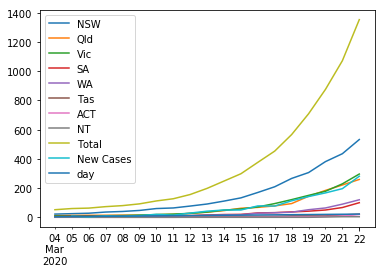

In [10]:
# Construct dataframe.
df = pd.DataFrame(data_rows, columns=head)
df.set_index('', inplace=True)
#df.drop(dt.date.today(), inplace=True)
df['day'] = (df.index-dt.datetime(2020,2,29)).days
df.plot()
plt.show()

In [11]:
df = df.loc[datestart:datetoday]
df.to_csv(raw_dir + 'data_au_' + datetodaystr + '.csv')

## Data pre-processing and visualization.

In [12]:
df_log = df.copy()

df_log[df_log<=0] = np.nan
df_log = df_log.apply(lambda x: np.log(x))
df_log['day'] = (df_log.index-dt.datetime(2020,2,29)).days

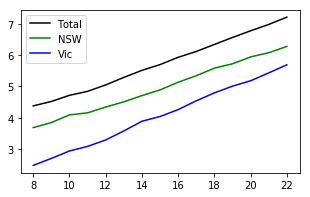

In [13]:
fig = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.plot(df_log.day, df_log.Total, 'k-')
ax.plot(df_log.day, df_log.NSW, 'g-')
ax.plot(df_log.day, df_log.Vic, 'b-')
ax.legend(loc='upper left')

In [14]:
data_x = df_log.day
data_y = df_log.Total
xmin = df_log.day[0]

def calc_rmse(est, obs):
    # make sure NaN is dropped.
    diff_2 = np.power(est-obs, 2)
    mse = np.sum(diff_2)/len(diff_2)
    return np.sqrt(mse)

def quick_polyfit(data_x, data_y):
    fit_full = np.polyfit(data_x, data_y, 1, full=True)
    a, b = fit_full[0]
    residuals = fit_full[1][0]
    r2 = 1 - residuals /data_y.var()/len(data_y)
    xfit = np.arange(daystart, dayend)
    yfit = a* xfit + b
    yfitlog = np.exp(a* xfit + b)
    rmse = calc_rmse(data_y.values, yfit[0:len(data_y)])
    return xfit, yfitlog, [a, b, r2, rmse]

In [15]:
fit_x, fit_y, fit_stat = quick_polyfit(df_log.day, df_log.Total)

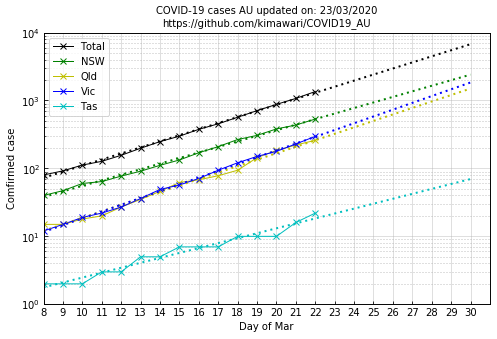

In [16]:
# DF in logarithmic scale. Linear fit.
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

states = ['Total',  'NSW', 'Qld', 'Vic', 'Tas']
color = {'Total': 'k', 'Vic': 'b',  'NSW': 'g',  'Qld': 'y', 'Tas': 'c'}
fit_stats = []

for state in states:
    ax.plot(df.day, df[state], 'x-', lw=1, c=color[state])
    fit_x, fit_y, fit_stat = quick_polyfit(df_log.day, df_log[state])
    ax.errorbar(fit_x, fit_y, dashes=(1,2), lw=2, c=color[state])
    fit_stat.append(state)
    fit_stats.append(fit_stat)

ax.set_title('COVID-19 cases AU updated on: ' + datetoday.strftime('%d/%m/%Y')
             + '\nhttps://github.com/kimawari/COVID19_AU', fontsize=10)
ax.set_xlabel('Day of Mar')
ax.set_ylabel('Comfirmed case')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_yticks([1, 10, 100, 1000, 10000])
ax.set_ylim(1, np.power(10, 4))
ax.set_xticks(np.arange(daystart, dayend))
ax.set_xlim(daystart, dayend)

ax2 = ax.twinx()
ax2.set_ylim(0, 4)
ax2.set_yticks([])
ax.grid(which='major', axis='both', dashes=(0.5,0.5))
ax.grid(which='minor', axis='both', dashes=(0.5,1))
ax.tick_params(which='both', direction='in')
ax2.tick_params(which='both', direction='in')

plt.savefig(out_dir + 'log_au_' + datetodaystr + '.png', dpi=dpi)

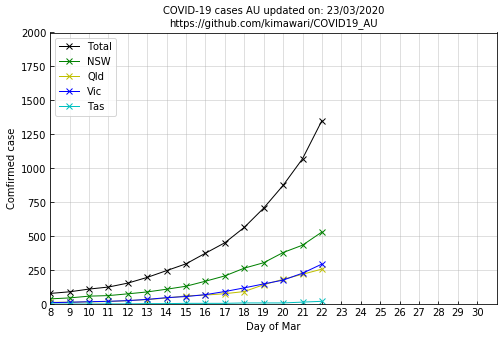

In [17]:
# DF in logarithmic scale. Linear fit.
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

states = ['Total',  'NSW', 'Qld', 'Vic', 'Tas']
color = {'Total': 'k', 'Vic': 'b',  'NSW': 'g',  'Qld': 'y', 'Tas': 'c'}
fit_stats = []

for state in states:
    ax.plot(df.day, df[state], 'x-', lw=1, c=color[state])
    fit_x, fit_y, fit_stat = quick_polyfit(df_log.day, df_log[state])
    #ax.errorbar(fit_x[0:14], fit_y[0:14], dashes=(1,2), lw=2, c=color[state])
    fit_stat.append(state)
    fit_stats.append(fit_stat)

ax.set_title('COVID-19 cases AU updated on: ' + datetoday.strftime('%d/%m/%Y')
             + '\nhttps://github.com/kimawari/COVID19_AU', fontsize=10)
ax.set_xlabel('Day of Mar')
ax.set_ylabel('Comfirmed case')
ax.legend(loc='upper left')
#ax.set_yscale('log')
#ax.set_yticks([1, 10, 100, 1000, 10000])
ax.set_ylim(0, 2000)
ax.set_xticks(np.arange(daystart, dayend))
ax.set_xlim(daystart, dayend)

ax.grid(which='major', axis='both', dashes=(0.5,0.5))
ax.grid(which='minor', axis='both', dashes=(0.5,1))
ax.tick_params(which='both', direction='in')

plt.savefig(out_dir + 'linear_au_' + datetodaystr + '.png', dpi=dpi)

## Export parameters.

In [18]:
df_para = pd.DataFrame(fit_stats, columns=['a', 'b', 'r2', 'rmse', 'state'])
df_para.set_index('state', inplace=True)
df_para.to_csv(in_dir + 'para_au_' + datetodaystr + '.csv')

In [19]:
df_para

,a,b,r2,rmse
state,,,,
Total,0.205742,2.641971,0.998253,0.038497
NSW,0.188482,2.127893,0.996956,0.046579
Qld,0.219062,0.738638,0.990560,0.095667
Vic,0.230170,0.611514,0.998694,0.037227
Tas,0.166951,-0.763957,0.964514,0.143400
